In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms #the mnist data set is imported in datasets
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline



In [7]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channels)
transform = transforms.ToTensor()

In [8]:
# train data
train_data = datasets.MNIST(root='/CNN_data',train =True,download=True,transform = transform )
#root- saving it into the directory , we download the data, then transform into 4D tensor

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.57MB/s]


In [9]:
# test data
test_data = datasets.MNIST(root='/CNN_data',train =False,download=True,transform = transform )


In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /CNN_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
# create small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)


In [11]:
#Define our CNN model
# describe convolutional layer and what it does (2 layers)
# 1st parameter=input 2nd = output 3rd = kernal size(filter matrix size) 4th= shift/ strude by how much
# conv2 must have an input same as the output of conv1
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

In [12]:
# grab 1 mnist image
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [13]:
X_Train.shape

torch.Size([1, 28, 28])

In [14]:
# 1- single image , 28 x 28 is the size of the image
x = X_Train.view(1,1,28,28)

In [18]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [19]:
x.shape # 26x26 is the size of image, decreased because padding was removed

torch.Size([1, 6, 26, 26])

In [20]:
# pooling layer
x = F.max_pool2d(x,2,2) # kernal of 2 and stride of 2


In [21]:
x.shape # image size has been shrunk to 13 / (26/2 = 13 )

torch.Size([1, 6, 13, 13])

In [22]:
# Do our second convolutional layer
x = F.relu(conv2(x))


In [23]:
x.shape      #11x11 we didnt set the padding , we lose 2 pixels around the outside of the image

torch.Size([1, 16, 11, 11])

In [24]:
# pooling layer
x = F.max_pool2d(x,2,2) # kernal of 2 and stride of 2

In [25]:
x.shape  # 11 / 2 = 5.5 but we have to round down, because you can't invent data to round up

torch.Size([1, 16, 5, 5])

In [26]:
#Model
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    X = X.view(-1, 16*5*5) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)



In [27]:

torch.manual_seed(41) # ensures the random nrs are same each time
model = ConvolutionalNetwork()  # create an instantance of the class
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the Learning Rate, longer its gonna take to train.

# adam is the name of the optimizer

In [29]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.1623610556125641
Epoch: 0  Batch: 1200  Loss: 0.1502392590045929
Epoch: 0  Batch: 1800  Loss: 0.4744560718536377
Epoch: 0  Batch: 2400  Loss: 0.14238706231117249
Epoch: 0  Batch: 3000  Loss: 0.007758188061416149
Epoch: 0  Batch: 3600  Loss: 0.3836284875869751
Epoch: 0  Batch: 4200  Loss: 0.0038223876617848873
Epoch: 0  Batch: 4800  Loss: 0.0021286322735249996
Epoch: 0  Batch: 5400  Loss: 0.0569545142352581
Epoch: 0  Batch: 6000  Loss: 0.00038789428072050214
Epoch: 1  Batch: 600  Loss: 0.005851339548826218
Epoch: 1  Batch: 1200  Loss: 0.3855525553226471
Epoch: 1  Batch: 1800  Loss: 0.004819948226213455
Epoch: 1  Batch: 2400  Loss: 0.003216963727027178
Epoch: 1  Batch: 3000  Loss: 0.0332382395863533
Epoch: 1  Batch: 3600  Loss: 0.5372857451438904
Epoch: 1  Batch: 4200  Loss: 0.04561494290828705
Epoch: 1  Batch: 4800  Loss: 0.0007510822033509612
Epoch: 1  Batch: 5400  Loss: 0.0001173773780465126
Epoch: 1  Batch: 6000  Loss: 0.14201366901397705
Epoch: 2  Batch

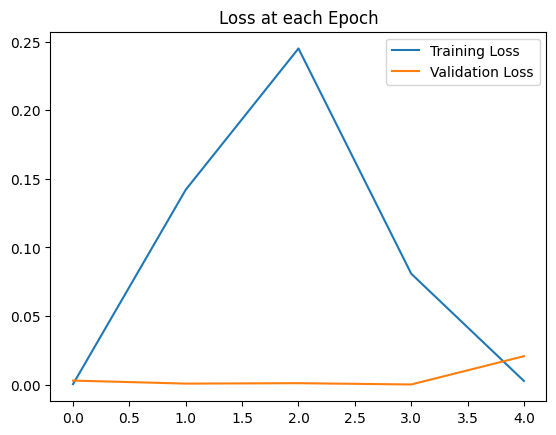

In [30]:
# graph the loss at each epoch

train_losses = [tl.item() for tl in train_losses] # convert tensor to python list
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at each Epoch")
plt.legend()


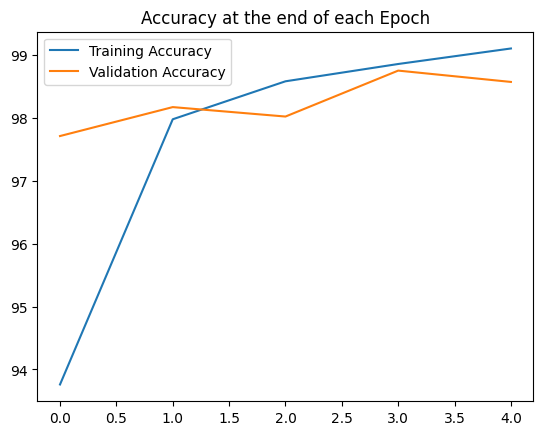

In [31]:
# graph the accuracy at the end of each epochs

plt.plot([t/600 for t in train_correct], label="Training Accuracy") # 600- for iterations of 600 defined above
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [33]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False) #getting a number of things we get correct
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()



In [34]:
correct.item()/len(test_data)*100

98.57000000000001

In [41]:
# putting a new image in the model
#grab the image
test_data[1900] # Tensor with an image in it...at end, it shows the label



(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [42]:
# grab the image without the label

test_data[1900][0]
# Reshape it
test_data[1978][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

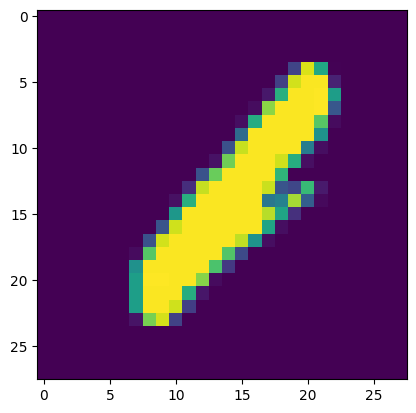

In [44]:
# Show the image
plt.imshow(test_data[1900][0].reshape(28,28))

In [47]:
# pass image through the model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1978][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image



In [48]:
# check prediction
new_prediction.argmax()

tensor(4)